# Greenland Crust Deformation
Code by Diego R. Varela Lugardo. Mentor: Surendra Adhikari

## Libraries

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import numpy as np
import scipy
import scipy.signal
import pandas as pd
import datetime
from datetime import timedelta

import os
from scipy.stats import pearsonr

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import GoogleTiles

import imageio

## Helper Functions

In [3]:
data_folder = '/Users/dlugardo/Desktop/data/ENU_v2' # path to the folder with the data 
# Loads the Metadata for all the station (latitude, longitude, and elevation)
StationMetaData = df = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/GreenlandStations.csv')

def get_data(location):
    file_name = str(location) + '.ENU.txt'
    path = os.path.join(data_folder, file_name)

    if os.path.isfile(path):
        data = np.loadtxt(path, skiprows=2)
    else:
        file_name = str(location) + '_ENU.txt'
        path = os.path.join(data_folder, file_name)

        if os.path.isfile(path):
            data = np.loadtxt(path, skiprows=2)
        else:
            raise FileNotFoundError(f"Neither '{location}.ENU.txt' nor '{location}_ENU.txt' found in {data_folder}")
    return data

def decimal_year_to_date(decimal_year):
    """
    Converts a decimal year to a datetime.date object.
    """
    year = int(decimal_year)
    fractional_part = decimal_year - year

    # Determine if it's a leap year for accurate day calculation
    is_leap = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    days_in_year = 366 if is_leap else 365

    # Calculate the number of days from the start of the year
    days_offset = fractional_part * days_in_year

    # Create a datetime object for January 1st of that year
    start_of_year = datetime.date(year, 1, 1)

    # Add the calculated offset in days
    result_date = start_of_year + datetime.timedelta(days=days_offset)

    return result_date

def doy_to_angle(doy):
    radians = doy * 2 * np.pi / 365
    mean_angle = np.arctan2(np.mean(np.sin(radians)), np.mean(np.cos(radians)))
    cos = np.cos(mean_angle)
    return(cos)

def circular_mean(degrees):
    radians = np.deg2rad(np.array(degrees) * 360/365)
    mean_angle = np.arctan2(np.mean(np.sin(radians)), np.mean(np.cos(radians)))
    mean_angle = np.rad2deg(mean_angle) * 365/360
    if mean_angle < 0:
        mean_angle += 365
    return mean_angle

MAX_GAP_DAYS = 30 

def find_longest_continuous_segment(dates, max_gap_days=30):
    # Ensure dates are sorted
    dates = np.sort(dates)
    segments = []
    current_segment = [dates[0]]

    for i in range(1, len(dates)):
        if (dates[i] - dates[i-1]).days <= max_gap_days:
            current_segment.append(dates[i])
        else:
            segments.append(current_segment)
            current_segment = [dates[i]]
    segments.append(current_segment)

    # Return the longest continuous segment
    return max(segments, key=len)

def InterpRA(data, detrend, INTERP_LIMIT, wdays):   
    time = data[:, 0]

    if detrend:   
        data[:, 1:4] = scipy.signal.detrend(data[:, 1:4], axis=0)
        
    # Convert decimal year to datetime
    converted_dates = np.array([decimal_year_to_date(dy) for dy in time])
    df = pd.DataFrame({'Date': pd.to_datetime(converted_dates)})
    df.set_index('Date', inplace=True)

    df['East'] = data[:, 1]
    df['North'] = data[:, 2]
    df['Vertical'] = data[:, 3]
    df['Horizontal'] =  np.sqrt(data[:, 1] ** 2 + data[:, 2] **2)
    df['3DDisp'] = np.cbrt(data[:, 1] ** 2 + data[:, 2] **2 + data[:, 3] **2)

    df['year'] = df.index.year
    df['doy'] = df.index.dayofyear

    filled_list = []
    for year, group in df.groupby('year'):
        # Determine if leap year
        is_leap = (pd.Timestamp(f'{year}-12-31').is_leap_year)
        days_in_year = 366 if is_leap else 365

        # Create full day-of-year range
        full_range = pd.DataFrame({'doy': np.arange(1, days_in_year + 1)})
        full_range['year'] = year

        # Merge to include missing days as NaN
        group = full_range.merge(group, on=['year', 'doy'], how='left')

        # Remove duplicates by averaging
        group = group.groupby(['year', 'doy'], as_index=False).mean()

        # Restore datetime index
        group['Date'] = pd.to_datetime(
            group['year'].astype(str) + '-' + group['doy'].astype(str),
            format='%Y-%j',
            errors='coerce'
        )
        group = group.set_index('Date').sort_index()

        # 🔹 Interpolate only small gaps
        for col in ['East', 'North', 'Vertical', 'Horizontal', '3DDisp']:
            group[col] = group[col].interpolate(
                method="time", limit=INTERP_LIMIT, limit_direction="both"
            )

        filled_list.append(group)

        
    # Concatenate all years
    df = pd.concat(filled_list).sort_index()
    
    # Apply rolling mean smoothing
    df_rolling = df.rolling(
        window=wdays, 
        center=True, 
        min_periods=wdays - int(wdays / 5)
    ).mean()
    df_rolling = df_rolling.dropna()

    # Remove Feb 29 for consistency
    df_rolling = df_rolling[df_rolling.index.strftime('%m-%d') != '02-29']
    
    # Reattach year, day of year, and month_day columns
    df_rolling['year'] = df_rolling.index.year
    df_rolling['month_day'] = df_rolling.index.strftime('%m-%d')
    df_rolling['doy'] = df_rolling.index.dayofyear

    leap_mask = df_rolling.index.is_leap_year & (df_rolling.index.month > 2)
    df_rolling.loc[leap_mask, 'doy'] -= 1
    
    return df_rolling

## Long Term Mean CSV creation
The code initializes with five different variables that will be utilized in the helper functions. 
1. The code retrieves the raw data, extracting the time component  and transforming it from decimal to normal format. 
2. The code searches for the longest 'continuous' segment (maximum gap days are controlled by MAX_GAP_DAYS variable). 
3. New Data Array is produced by masking the raw data to get the longest 'continuous' segment.
4. Data is passed through InterpRA function. The function does the following:
    - If Detrend = True, it linearly detrends the data using scipy.signal
    - Displacement and Error Data is extracted. Five timeseries are created for the displacement vectors: East, North, Vertical, Horizontal, 3DDisp (cubic root of the sum of the 1D displacement vectors).
    - Linearly Interpolates missing values (variable here to set maximum of days)
    - Rolling Average is produced
    - Nan values are dropped 
    - February 29 is eliminated so that all years have 365 days
    - New Dataset is returned
5. If a specific day has less data points that accepted (min_years_per_doy), it gets masked.
6. Long Term Mean (LTM) and Standard Deviation (StDevs) are computed for every day of the year for all five components.
7. A rolling average (3 day window) is applied to the resultant LTM to smooth out. 
8. LTM and StDevs are exported as a single file

In [7]:
stations_names_with_data, metadata_records = [], []

MAX_GAP_DAYS = 60        # Maximum gap acceptable between data
INTERP_LIMIT = 8         # Maximum of days to be interpolated
wdays = 30               # Rolling Average window (number of days considered in the average)
MIN_DAYS_PER_YEAR = 350  # Minimum days required to be considered as a full year. 
min_years_of_data = 3    # Minimum length of the continuous segment

Save = False

for station_name in StationMetaData.station:
    try:
        raw_data = get_data(station_name)
        time = raw_data[:, 0]
        converted_dates = np.array([decimal_year_to_date(dy) for dy in time])

        # Find longest continuous segment of data
        continuous_segment = find_longest_continuous_segment(
            converted_dates, max_gap_days=MAX_GAP_DAYS
        )

        if len(continuous_segment) < 365 * min_years_of_data:  # optional: skip if segment is too short
            print(f"  → Skipping {station_name}: continuous segment too short.")
            continue

        if Save is False:
            stations_names_with_data.append(station_name)
            continue

        # Filter both data and error to this segment
        mask = np.isin(converted_dates, continuous_segment)
        data = raw_data[mask, :]

        df_rolling = InterpRA(data, True, INTERP_LIMIT, wdays)

        valid_years = df_rolling.groupby('year').filter(
            lambda x: len(x) >= MIN_DAYS_PER_YEAR
        )['year'].unique()
        df_rolling = df_rolling[df_rolling['year'].isin(valid_years)]
        
        LTM = df_rolling.groupby('month_day')[['East', 'North', 'Vertical','Horizontal', '3DDisp']].mean()
        stds = df_rolling.groupby('month_day')[['East', 'North', 'Vertical','Horizontal', '3DDisp']].std()
        
        stds.columns = ['East_sd', 'North_sd', 'Vertical_sd','Horizontal_sd', '3DDisp_sd']
        LTM = LTM.join(stds)

        LTM[['East','North','Vertical', 'Horizontal', '3DDisp' ]] = (
            LTM[['East','North','Vertical', 'Horizontal', '3DDisp']].rolling(3, center=True, min_periods=1).mean()
        )

        # Save LTM for this station
        if Save is True:
            LTM.to_csv(f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/{station_name}_Daily{wdays}RollingLTM.csv', index=True)

        stations_names_with_data.append(station_name)

    except FileNotFoundError:
        print(f"  → File not found for station {station_name}. Skipping.")
        continue
    except Exception as e:
        print(f"  → Error processing station {station_name}: {e}")
        continue

  → Skipping NGFJ: continuous segment too short.
  → File not found for station THU4. Skipping.
  → File not found for station QENU. Skipping.
  → File not found for station AAS2. Skipping.
  → Skipping EQNU: continuous segment too short.
  → Skipping SCOB: continuous segment too short.
  → File not found for station SCO4. Skipping.
  → File not found for station STNO. Skipping.
  → File not found for station QAQ2. Skipping.
  → File not found for station KLQ3. Skipping.
  → Skipping UPAK: continuous segment too short.
  → Skipping AVAN: continuous segment too short.
  → File not found for station THU3. Skipping.
  → Skipping NUNA: continuous segment too short.
  → File not found for station KSUT. Skipping.


In [9]:
np.shape(stations_names_with_data)

(61,)

## Plotting of the Data
Note that the StDev is quite big as there is a lot of fluctuation in the mean of every year (Multidecadal systems). This StDev is not as useful.

In [ ]:
# Load data
station = 'SRMP'
climatology_daily = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/' + station + '_Daily30RollingLTM.csv') # ',{station_name}_Daily{wdays}RollingLTM.csv

# Set up the figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(22, 10), sharex=True)

# Define colors
colors = {'East': '#1f77b4', 'North': '#ff7f0e', 'Vertical': '#2ca02c'}

# Plot each component
components = ['East', 'North', 'Vertical']
titles = ['East Detrended (mm)', 'North Detrended (mm)', 'Vertical Detrended (mm)']

for i, component in enumerate(components):
    ax = axs[i]
    sd = climatology_daily[component + '_sd']
    ax.plot(climatology_daily['month_day'], climatology_daily[component], label=f'{component.title()} Mean', color=colors[component])
    ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')

    # 1-sigma shading
    ax.fill_between(climatology_daily['month_day'],
                    climatology_daily[component] - sd,
                    climatology_daily[component] + sd,
                    color=colors[component], alpha=0.2, label='±1σ')

    # 2-sigma only for 'up'
    if component == 'Vertical':
        ax.fill_between(climatology_daily['month_day'],
                        climatology_daily[component] - 2 * sd,
                        climatology_daily[component] + 2 * sd,
                        color=colors[component], alpha=0.1, label='±2σ')

    ax.set_title(titles[i], fontsize=13, weight='bold')
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_ylabel('Displacement (mm)', fontsize=11)

# X-axis settings
#axs[-1].set_xlabel('Date (MM-DD)', fontsize=12)
axs[-1].xaxis.set_major_locator(mdates.MonthLocator())
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Rotate x labels
plt.setp(axs[-1].xaxis.get_majorticklabels(), rotation=45)

# Add overall title
fig.suptitle(f'{station} Long Term Mean Displacement (30-Day Rolling Average)', fontsize=16, weight='bold', y=1.02)

# Final layout tweaks
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

## 'Compressed' Anomalies
To observe the 'seasonal' behavior and take out multi-year oscillations, the data is compressed so that every year has an average of zero. 
Each year is averaged and the average is substracted to the same year, plotting the anomaly to respect that year. 

In [ ]:
DispAll = ['Vertical', 'Horizontal', '3DDisp']

for station_name in stations_names_with_data:
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)  # 3 rows, 1 col

    legend_handles = []
    legend_labels = []
    n_years = 0  # counter

    for j, Disp in enumerate(DispAll):
        ax = axes[j]  # select subplot
        
        raw_data = get_data(station_name)
        INTERP_LIMIT = 3  
        wdays = 30
        rd_data = InterpRA(raw_data, True, INTERP_LIMIT, wdays )

        years = sorted(np.unique(rd_data.year))
        colormap = cm.get_cmap('viridis', len(years))

        ax.set_ylabel(f'{Disp} Displacement (mm)', fontsize=12)
        ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')
        ax.set_xlim(0, 365)

        days = np.arange(1, 366)
        all_years_df = []

        # Load LTM
        LTM = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/SRMP_Daily30RollingLTM.csv')
        LTM = LTM[Disp]
        offset_LTM = np.array(LTM - np.nanmean(LTM))

        for year in years:
            data = rd_data[rd_data['year'] == year].copy()
            if data[Disp].count() < 350:
                continue
            data[Disp] = data[Disp] - np.nanmean(data[Disp])
            all_years_df.append(data)

        if len(all_years_df) == 0:
            continue  # skip if no valid years

        all_years_df = pd.concat(all_years_df)
        STD = np.array(all_years_df.groupby('doy')[Disp].std())

        # update year count once (first subplot is enough)
        if j == 0:
            n_years = len(all_years_df['year'].unique())

        # bands
        upper1 = offset_LTM + STD
        lower1 = offset_LTM - STD
        upper2 = offset_LTM + STD * 2
        lower2 = offset_LTM - STD * 2
        upper15 = offset_LTM + STD * 1.8
        lower15 = offset_LTM - STD * 1.8

        # Plot mean and bands
        ax.plot(days, offset_LTM, lw=2, c='red', label='Mean')
        ax.fill_between(days, lower1, upper1, color='red', alpha=0.2, label='±1σ')
        #ax.fill_between(days, lower2, upper2, color='red', alpha=0.1, label='±2σ')

        # Collect handles for legend only once (first loop)
        if j == 0:
            handles, labels = ax.get_legend_handles_labels()
            legend_handles.extend(handles)
            legend_labels.extend(labels)

        for i, year in enumerate(sorted(all_years_df['year'].unique())):
            yr = all_years_df[all_years_df['year'] == year].set_index("doy")
            yr_disp = yr[Disp]
            idx = yr.index.values - 1  

            yr_upper = upper15[idx]
            yr_lower = lower15[idx]

            mask_upper = yr_disp.values > yr_upper
            mask_lower = yr_disp.values < yr_lower
            outside_frac = (mask_upper.sum() + mask_lower.sum()) / len(yr_disp)

            # if outside_frac >= 0.1:
            #     ax.plot(yr.index, yr_disp.values, lw=1.5, color=colormap(i), label=str(year))
            # else:
            #     ax.plot(yr.index, yr_disp.values, lw=1.0, color=colormap(i), alpha=0.1)

    # shared x-axis labels
    axes[-1].set_xlabel("Day of Year", fontsize=12)

    # use f-string for dynamic year count
    fig.suptitle(f'Detrended - Average Displacement at {station_name}\n n = {n_years} years',
                 fontsize=16, weight='bold')

    # One legend for all, at the bottom
    fig.legend(legend_handles, legend_labels,
               loc="lower center", ncol=len(legend_labels), frameon=True)

    plt.tight_layout(rect=[0.0, 0.02, .98, 1.005])  # extra space for legend + title
    filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/AverageDisplacement/AvgDisplacement_{station_name}_Anomalies.png'
    plt.savefig(filename, dpi=300)
    plt.close()


## Metrics
Calculate Amplitude, DoY of peak & minima, and correlation to the LTM. This uses the yearly anomaly data. It then plots it but does not store the values.

In [ ]:
## Each displacement as its own figure.

DispAll = ['Vertical','Horizontal', '3DDisp']

for station_name in stations_names_with_data:
    for Disp in DispAll:
        # --- Load and preprocess data ---
        raw_data = get_data(station_name)
        INTERP_LIMIT = 3
        wdays = 30
        df_rolling = InterpRA(raw_data, True, INTERP_LIMIT, wdays)

        years = sorted(np.unique(df_rolling.year))

        # Load LTM
        LTM = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/SRMP_Daily30RollingLTM.csv')
        LTM_vals = LTM[Disp].values
        offset_LTM = LTM_vals - np.nanmean(LTM_vals)

        peak_doy, min_doy, amplitude, corr_ltm = [], [], [], []
        years_used = []

        for year in years:
            data = df_rolling[df_rolling['year'] == year].copy()
            if data.shape[0] < 350:
                continue
            
            # Yearly anomaly
            anomaly = data[Disp] - np.nanmean(data[Disp])
            
            # Peak/min DOY
            max_idx = anomaly.idxmax()
            min_idx = anomaly.idxmin()
            peak_doy.append(data.loc[max_idx, 'doy'])
            min_doy.append(data.loc[min_idx, 'doy'])

            # Amplitude
            amplitude.append(anomaly.max() - anomaly.min())

            # Correlation with LTM
            idx = data['doy'].values - 1  # align with LTM index
            corr, _ = pearsonr(anomaly.values, offset_LTM[idx])
            corr_ltm.append(corr)

            years_used.append(str(year))

        # Add circular mean / average column
        peak_doy.append(circular_mean(peak_doy))
        min_doy.append(circular_mean(min_doy))
        amplitude.append(np.mean(amplitude))
        corr_ltm.append(np.mean(corr_ltm))
        years_used.append('Mean')

        # --- Convert to arrays for heatmaps ---
        arr_doy = np.vstack([peak_doy, min_doy])
        arr_amp = np.array([amplitude])
        arr_corr = np.array([corr_ltm])

        # --- Create figure with height ratios {2,1,1} ---
        fig, axes = plt.subplots(
            3, 1, figsize=(9, 4), 
            constrained_layout=False, 
            gridspec_kw={'height_ratios': [1.8,1,1]}
        )
        plt.subplots_adjust(hspace=0)  # remove vertical gaps

        # 1. Peak & Min DOY
        im1 = axes[0].imshow(arr_doy, aspect='auto', cmap='plasma', vmin=0, vmax=365)
        axes[0].set_yticks([0,1])
        axes[0].set_yticklabels(['Peak DOY','Min DOY'])
        axes[0].set_xticks(np.arange(len(years_used)))
        axes[0].set_xticklabels(years_used, rotation=45)
        fig.colorbar(im1, ax=axes[0], orientation='vertical', label='DOY', fraction=0.025, pad=0.02, shrink = 0.6)
        for row in range(arr_doy.shape[0]):
            axes[0].text(arr_doy.shape[1]-1, row, f"{arr_doy[row,-1]:.1f}",
                        ha='center', va='center', color='white', fontsize=9)

        # 2. Amplitude
        im2 = axes[1].imshow(arr_amp, aspect='auto', cmap='viridis')
        axes[1].set_yticks([0])
        axes[1].set_yticklabels(['Amplitude'])
        axes[1].set_xticks(np.arange(len(years_used)))
        axes[1].set_xticklabels(years_used, rotation=45)
        fig.colorbar(im2, ax=axes[1], orientation='vertical', label='Amplitude', fraction=0.025, pad=0.02, shrink = 0.8)
        axes[1].text(arr_amp.shape[1]-1, 0, f"{arr_amp[0,-1]:.2f}",
                    ha='center', va='center', color='white', fontsize=9)

        # 3. Correlation with LTM
        im3 = axes[2].imshow(arr_corr, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
        axes[2].set_yticks([0])
        axes[2].set_yticklabels(['Corr LTM'])
        axes[2].set_xticks(np.arange(len(years_used)))
        axes[2].set_xticklabels(years_used, rotation=45)
        fig.colorbar(im3, ax=axes[2], orientation='vertical', label='Correlation', fraction=0.025, pad=0.02, shrink = 0.8)
        axes[2].text(arr_corr.shape[1]-1, 0, f"{arr_corr[0,-1]:.2f}",
                    ha='center', va='center', color='white', fontsize=9)

        fig.suptitle(f"{station_name} {Disp} Displacement Yearly Anomaly", fontsize=16, y=0.93)
        filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/Metrics/Metrics_{station_name}_{Disp}.png'
        plt.savefig(filename, dpi=300)  
        plt.close()

The following code will do everything in a single figure.

In [ ]:
## All the displacements on a single figure.
DispAll = ['Vertical','Horizontal','3DDisp']

for station_name in stations_names_with_data:
    # --- Load and preprocess data once ---
    raw_data = get_data(station_name)
    INTERP_LIMIT = 3
    wdays = 30
    df_rolling = InterpRA(raw_data, True, INTERP_LIMIT, wdays)

    years = sorted(np.unique(df_rolling.year))

    # Load LTM once
    LTM = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/SRMP_Daily30RollingLTM.csv')
    
    # Containers for all displacements
    all_peak_doy, all_min_doy, all_amplitude, all_corr_ltm = [], [], [], []

    for Disp in DispAll:
        LTM_vals = LTM[Disp].values
        offset_LTM = LTM_vals - np.nanmean(LTM_vals)

        peak_doy, min_doy, amplitude, corr_ltm = [], [], [], []
        years_used = []

        for year in years:
            data = df_rolling[df_rolling['year'] == year].copy()
            if data.shape[0] < 350:
                continue
            
            anomaly = data[Disp] - np.nanmean(data[Disp])

            # Peak/min DOY
            max_idx = anomaly.idxmax()
            min_idx = anomaly.idxmin()
            peak_doy.append(data.loc[max_idx, 'doy'])
            min_doy.append(data.loc[min_idx, 'doy'])

            # Amplitude
            amplitude.append(anomaly.max() - anomaly.min())

            # Correlation with LTM
            idx = data['doy'].values - 1
            corr, _ = pearsonr(anomaly.values, offset_LTM[idx])
            corr_ltm.append(corr)

            years_used.append(str(year))

        # Add mean row
        peak_doy.append(circular_mean(peak_doy))
        min_doy.append(circular_mean(min_doy))
        amplitude.append(np.mean(amplitude))
        corr_ltm.append(np.mean(corr_ltm))
        
        years_used.append('Mean')

        # Collect for all displacements
        all_peak_doy.append(peak_doy)
        all_min_doy.append(min_doy)
        all_amplitude.append(amplitude)
        all_corr_ltm.append(corr_ltm)

    # --- Convert to arrays for heatmaps ---
    arr_doy = np.vstack([np.array(p) for pair in zip(all_peak_doy, all_min_doy) for p in pair])
    # rows = [Peak_V, Min_V, Peak_H, Min_H, Peak_3D, Min_3D]
    arr_amp = np.vstack(all_amplitude)   # shape (3, years+Mean)
    arr_corr = np.vstack(all_corr_ltm)   # shape (3, years+Mean)

    # --- Create figure ---
    fig, axes = plt.subplots(
        3, 1, figsize=(11, 6), 
        constrained_layout=False, 
        gridspec_kw={'height_ratios': [1.8,1,1]}
    )
    plt.subplots_adjust(hspace=0)

    # 1. Peak & Min DOY
    im1 = axes[0].imshow(arr_doy, aspect='auto', cmap='plasma', vmin=0, vmax=365)
    yticks = [f"Peak {disp}" for disp in DispAll] + [f"Min {disp}" for disp in DispAll]
    axes[0].set_yticks(np.arange(arr_doy.shape[0]))
    axes[0].set_yticklabels(yticks)
    axes[0].set_ylabel("DOY", fontsize=12, rotation=90, labelpad=10)
    axes[0].set_xticks(np.arange(len(years_used)))
    axes[0].set_xticklabels(years_used, rotation=45)
    fig.colorbar(im1, ax=axes[0], orientation='vertical', label='DOY', fraction=0.025, pad=0.02, shrink=0.6)

    for row in range(arr_doy.shape[0]):
        axes[0].text(arr_doy.shape[1]-1, row, f"{arr_doy[row,-1]:.1f}",
                     ha='center', va='center', color='white', fontsize=9)

    # 2. Amplitude
    im2 = axes[1].imshow(arr_amp, aspect='auto', cmap='viridis')
    axes[1].set_yticks(np.arange(len(DispAll)))
    axes[1].set_yticklabels(DispAll)
    axes[1].set_ylabel("Amplitude", fontsize=12, rotation=90, labelpad=10)
    axes[1].set_xticks(np.arange(len(years_used)))
    axes[1].set_xticklabels(years_used, rotation=45)
    fig.colorbar(im2, ax=axes[1], orientation='vertical', label='Amplitude', fraction=0.025, pad=0.02, shrink=0.8)

    for row in range(arr_amp.shape[0]):
        axes[1].text(arr_amp.shape[1]-1, row, f"{arr_amp[row,-1]:.2f}",
                     ha='center', va='center', color='white', fontsize=9)

    # 3. Correlation with LTM
    im3 = axes[2].imshow(arr_corr, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
    axes[2].set_yticks(np.arange(len(DispAll)))
    axes[2].set_yticklabels(DispAll)
    axes[2].set_ylabel("Corr LTM", fontsize=12, rotation=90, labelpad=10)
    axes[2].set_xticks(np.arange(len(years_used)))
    axes[2].set_xticklabels(years_used, rotation=45)
    fig.colorbar(im3, ax=axes[2], orientation='vertical', label='Correlation', fraction=0.025, pad=0.02, shrink=0.8)

    for row in range(arr_corr.shape[0]):
        axes[2].text(arr_corr.shape[1]-1, row, f"{arr_corr[row,-1]:.2f}",
                     ha='center', va='center', color='white', fontsize=9)

    fig.suptitle(f"{station_name} Displacement Yearly Anomalies", fontsize=16, y=0.93)
    filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/Metrics/Metrics_{station_name}.png'
    plt.savefig(filename, dpi=300)  
    plt.close()

## Heatmap of Horizontal Displacement

First block of the code creates a pandas dataframe with all the relevant metrics and the second one plots it.

In [5]:
INTERP_LIMIT = 8
wdays = 30

DispAll = ['Horizontal', 'Vertical']
records = []

for station_name in stations_names_with_data:
    raw_data = get_data(station_name)
    df_rolling = InterpRA(raw_data, True, INTERP_LIMIT, wdays)

    # station metadata
    smdt = StationMetaData.loc[StationMetaData['station'] == station_name]
    lon, lat = smdt.longitude, smdt.latitude

    for year in sorted(np.unique(df_rolling.year)):
        data = df_rolling[df_rolling['year'] == year].copy()
        if data.shape[0] < 300:
            # still record "empty" entry
            for Disp in DispAll:
                records.append({
                    "station": station_name,
                    "lon": lon,
                    "lat": lat,
                    "year": year,
                    "disp": Disp,
                    "Peak_DoY": np.nan,
                    "Min_Doy": np.nan,
                    "Amplitude": np.nan
                })
            continue

        for Disp in DispAll:
            anomaly = data[Disp] - np.nanmean(data[Disp])
            max_idx = anomaly.idxmax()
            min_idx = anomaly.idxmin()

            records.append({
                "station": station_name,
                "lon": lon,
                "lat": lat,
                "year": year,
                "disp": Disp,
                "Peak_DoY": data.loc[max_idx, "doy"],
                "Min_DoY": data.loc[min_idx, "doy"],
                "Amplitude": anomaly.max() - anomaly.min()
            })

# ---- Build DataFrame ----
df_metrics = pd.DataFrame(records)

In [ ]:
DispAll = ['Horizontal', 'Vertical']#, '3DDisp']
Metrics = [ 'Min_DoY']#, 'Amplitude'] 'Amplitude', 'Peak_DoY',

tiler = GoogleTiles(style="satellite")

for Metric in Metrics:
    for Disp in DispAll:
        if Disp == 'Vertical' and Metric == 'Amplitude':
            cmap = mpl.colormaps['jet'].resampled(20)
            vmin = 0
            vmax = 20
            norm = colors.Normalize(vmin=vmin, vmax=vmax)
    
        elif Disp == 'Horizontal' and Metric == 'Amplitude':
            cmap = mpl.colormaps['jet'].resampled(20)
            vmin = 0
            vmax = 10
            norm = colors.Normalize(vmin=vmin, vmax=vmax)

        elif Metric == 'Peak_DoY' or 'Min_DoY':
            cmap = mpl.colormaps['jet'].resampled(100)
            vmin = 0
            vmax = 365
            norm = colors.Normalize(vmin=vmin, vmax=vmax)

        filenames = []
        for year in sorted(df_metrics["year"].unique()):

            fig = plt.figure(figsize=(8, 11))
            ax = plt.axes(projection=ccrs.Stereographic())
            if Metric == 'Amplitude':
                plt.title(f"{Disp} Displacement (Peak-to-Peak Amplitude) ({year})")

            elif Metric == 'Peak_DoY':
                plt.title(f"{Disp} Day of Maximum Displacement ({year})")
            
            elif Metric == 'Min_DoY':
                plt.title(f"{Disp} Day of Minimum Displacement ({year})")

            ax.set_extent([-55, -5, 55, 90])
            ax.add_image(tiler,6)
            ax.gridlines(draw_labels=True)
            ax.stock_img()
            ax.coastlines(resolution="10m", alpha=0.3)

            # Filter dataframe
            df_sub = df_metrics[(df_metrics["disp"] == Disp) & (df_metrics["year"] == year)]

            for _, row in df_sub.iterrows():
                if np.isnan(row[Metric]):
                    # No data → empty marker
                    ax.scatter(
                        row["lon"], row["lat"],
                        facecolors="none",
                        edgecolors="k",
                        s=100,
                        linewidth=1,
                        transform=ccrs.PlateCarree()
                    )
                else:
                    # Filled marker
                    ax.scatter(
                        row["lon"], row["lat"],
                        c=[row[Metric]],
                        cmap=cmap,
                        norm=norm,
                        s=150,
                        edgecolor="k",
                        linewidth=0.5,
                        alpha = 1,
                        transform=ccrs.PlateCarree()
                    )

            # --- Colorbar ---
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax, orientation="vertical", shrink=0.6, pad=0.02)
            if Metric == 'Amplitude':
                cbar.set_label("Amplitude (mm)")

            else:
               cbar.set_label("Day of Year")

            plt.tight_layout()
            filename = f"/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/{Disp}_{Metric}_{year}_Detrended_Yearly.png"
            plt.savefig(filename)
            filenames.append(filename)
            plt.close()
        
        # --- Build GIF --- 
        with imageio.get_writer(f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/{Disp}_{Metric}_Detrended_Yearly.gif', mode='I', duration=300) as writer: 
            for filename in filenames: 
                image = imageio.imread(filename) 
                writer.append_data(image)
        
        # --- Build MP4 --- 
        with imageio.get_writer(f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/{Disp}_{Metric}_Detrended_Yearly.mp4', fps=2) as writer:
            for filename in filenames: 
                image = imageio.imread(filename) 
                writer.append_data(image)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (800, 1100) to (800, 1104) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x7fb247f12940] Stream #0: not enough frames to estimate rate; consider increasing probesize


<urlopen error [Errno 8] nodename nor servname provided, or not known>


### TO DO
1. Produce 3 snaps characterizing the nominal amplitude and timing of maximum subsidence and upflift for vertical (LTM)\
2. Same as 1 but for different episodes (five year intervals (consult Grace-altimetry data))
3. Repeat item 1 for all stations\hor\
4. Overlay with model prediction


## Characteristic Map
First cell of code creates the metrics ploted (similar to a code before) and second one plots it. This code uses the LTM previously calculated to obtain the metrics.

In [66]:
DispAll = ['Vertical']
recordsavg = []

for station_name in stations_names_with_data:
    LTM = pd.read_csv(f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/{station_name}_Daily30RollingLTM.csv')

    smdt = StationMetaData.loc[StationMetaData['station'] == station_name]
    lon, lat = smdt.longitude, smdt.latitude

    for Disp in DispAll:
        LTM_vals = LTM[Disp].values

        max_idx = np.argmax(LTM_vals)
        min_idx = np.argmin(LTM_vals)
        amp = np.max(LTM_vals) - np.min(LTM_vals)
        dt = np.abs(max_idx - min_idx)

        raw_data = get_data(station_name)
        INTERP_LIMIT = 8  
        wdays = 30
        rd_data = InterpRA(raw_data, True, INTERP_LIMIT, wdays )
        max_ay, min_ay, amp_ay, dt_ay = [], [], [], []

        years = sorted(np.unique(rd_data.year))

        for year in years:
            data = rd_data[rd_data['year'] == year].copy()
            if data[Disp].count() < 350:
                continue
            data = data[Disp] - np.nanmean(data[Disp])

            max_ay.append(np.argmax(data.values))
            min_ay.append(np.argmin(data.values))
            dt_ay.append(np.abs(np.argmax(data.values) - np.argmin(data.values) ))
            amp_ay.append(np.max(data.values) - np.min(data.values))

        STDpc_amp = np.std(amp_ay) / ( amp ) * 100
    
        STD_dt = np.std(dt_ay)
        STD_p = scipy.stats.circstd(max_ay, high=366, low=1) 
        STD_m = scipy.stats.circstd(min_ay, high=366, low=1)  
        

        recordsavg.append({
                    "station": station_name,
                    "lon": lon,
                    "lat": lat,
                    "disp": Disp,
                    "Amplitude": amp,
                    "Peak_DoY": max_idx,
                    "Min_DoY": min_idx,
                    "Time_PeaktoMin": dt,
                    "Amplitude_StDev": STDpc_amp,
                    "Peak_DoY_StDev": STD_p,
                    "Min_DoY_StDev": STD_m,
                    "Time_PeaktoMin_StDev" : STD_dt,
                    
                })
        
df_metricsavg = pd.DataFrame(recordsavg)

In [67]:
df_metricsavg

,station,lon,lat,disp,Amplitude,Peak_DoY,Min_DoY,Time_PeaktoMin,Amplitude_StDev,Peak_DoY_StDev,Min_DoY_StDev,Time_PeaktoMin_StDev
0,JWLF,"1 -45.119847 Name: longitude, dtype: float64","1 83.111656 Name: latitude, dtype: float64",Vertical,6.425754,256,164,92,27.242708,62.514713,42.848218,62.745471
1,JGBL,"3 -31.004208 Name: longitude, dtype: float64","3 82.208758 Name: latitude, dtype: float64",Vertical,7.871092,248,141,107,36.044969,60.101622,59.498566,42.887192
2,THU2,"4 -68.82505 Name: longitude, dtype: float64","4 76.537047 Name: latitude, dtype: float64",Vertical,6.437598,267,141,126,31.421148,51.065865,36.402289,53.762068
3,NNVN,"5 -44.901069 Name: longitude, dtype: float64","5 61.631878 Name: latitude, dtype: float64",Vertical,15.587793,299,73,226,50.476732,38.940624,48.198475,54.465913
4,YMER,"7 -24.326331 Name: longitude, dtype: float64","7 77.432897 Name: latitude, dtype: float64",Vertical,10.984600,258,142,116,74.589200,39.342873,51.058854,50.006933
...,...,...,...,...,...,...,...,...,...,...,...,...
56,UTMG,"70 -43.306422 Name: longitude, dtype: float64","70 62.927208 Name: latitude, dtype: float64",Vertical,12.529252,298,155,143,23.814083,47.644883,18.756674,25.676629
57,MIK2,"71 -31.451825 Name: longitude, dtype: float64","71 68.140281 Name: latitude, dtype: float64",Vertical,12.659447,324,162,162,32.051404,41.990753,30.183092,46.939468
58,KUAQ,"72 -33.05275 Name: longitude, dtype: float64","72 68.587 Name: latitude, dtype: float64",Vertical,13.085003,252,140,112,40.069915,47.993142,25.508113,40.714453
59,RINK,"74 -50.993967 Name: longitude, dtype: float64","74 71.8485 Name: latitude, dtype: float64",Vertical,9.646023,333,165,168,35.037049,61.726361,26.450702,33.970168


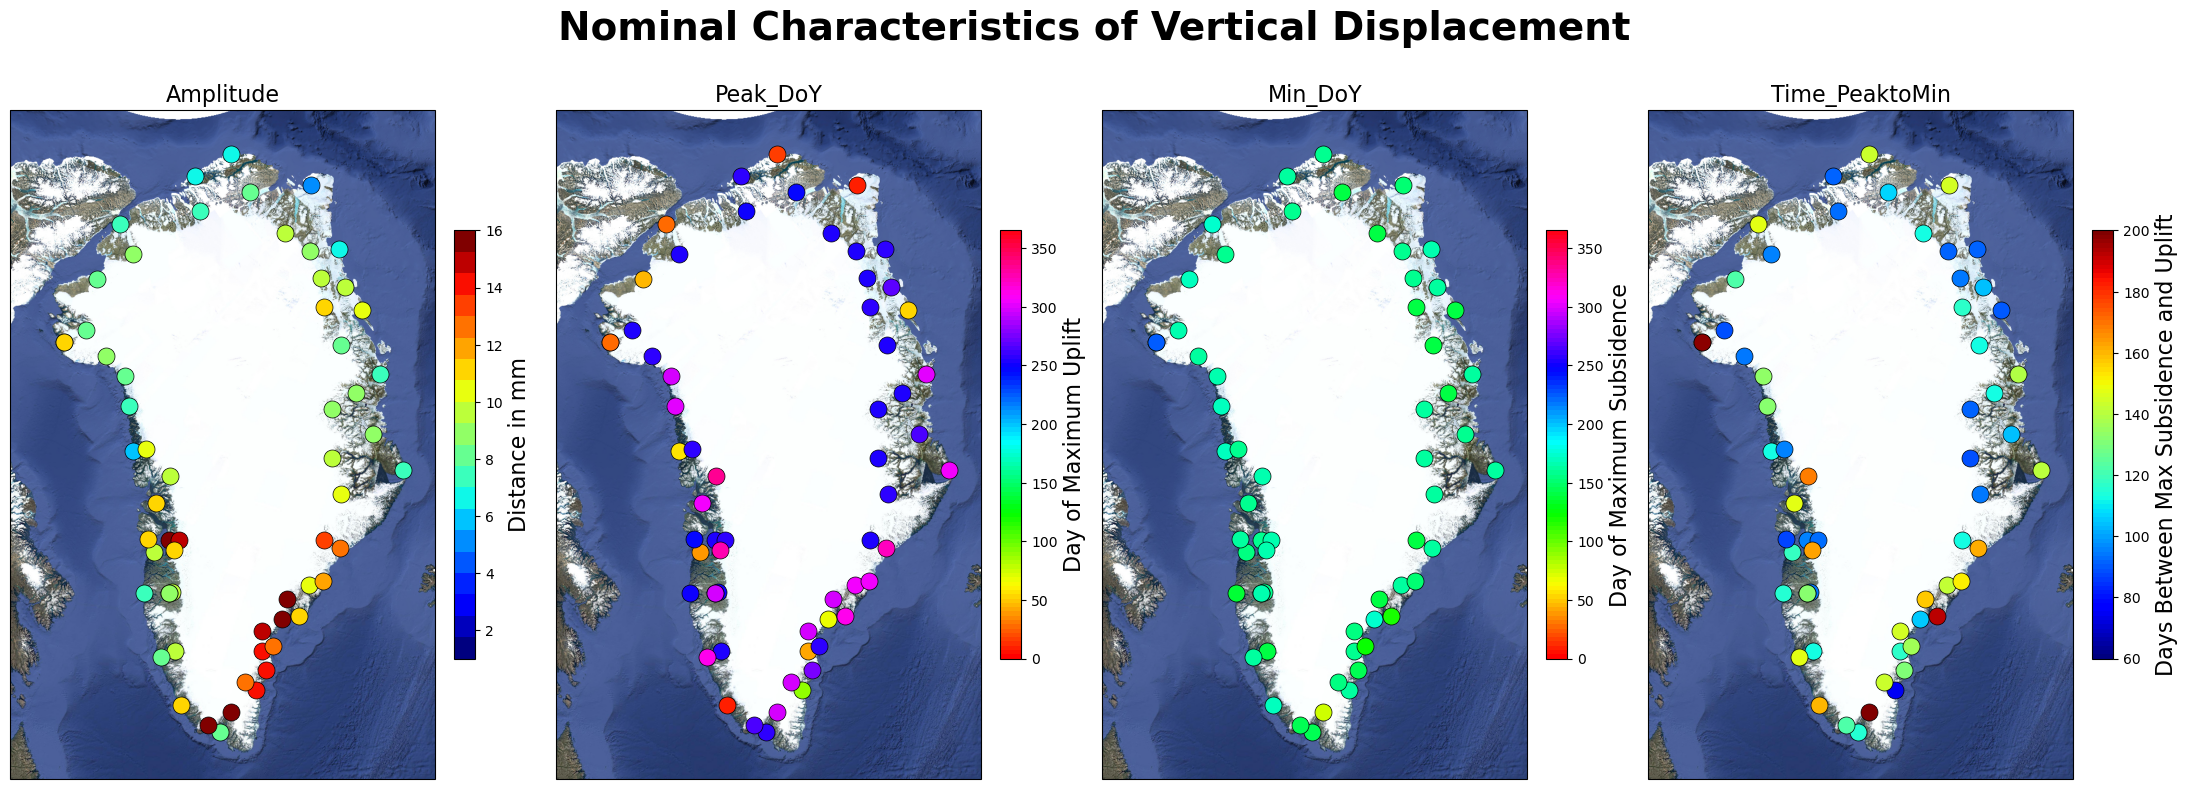

In [82]:
tiler = GoogleTiles(style="satellite") # Opens Satellite Image

fig, ax = plt.subplots(1,4, figsize=(22, 8.5), sharey=True, subplot_kw={'projection': ccrs.Stereographic(central_longitude=-50)}) ## Creates subplots

extent = [-65, -27, 58, 85]

Disp = 'Vertical'
Metrics = ['Amplitude', 'Peak_DoY', 'Min_DoY', 'Time_PeaktoMin']
df_sub = df_metricsavg[(df_metricsavg["disp"] == Disp)] # Dataset opens
Labels = {'Amplitude_StDev': 'Percentage of LTM %', 'Peak_DoY_StDev': 'Standard Deviation in # Days', 'Min_DoY_StDev': 'Standard Deviation in # Days',
          'Amplitude': 'Distance in mm', 'Peak_DoY': 'Day of Maximum Uplift', 'Min_DoY': 'Day of Maximum Subsidence', 
          'Time_PeaktoMin_StDev':'Days Between Max Subsidence and Uplift (StDev)', 'Time_PeaktoMin' : 'Days Between Max Subsidence and Uplift'}

for a in ax:
    a.set_extent(extent, crs=ccrs.PlateCarree())  
    a.add_image(tiler, 6)

for i, Metric in enumerate(Metrics):
    if Metric == 'Amplitude':
            cmap = mpl.colormaps['jet'].resampled(20)
            vmin = 1
            vmax = 16
            norm = colors.Normalize(vmin=vmin, vmax=vmax)

    elif Metric == 'Amplitude_StDev':
            cmap = mpl.colormaps['jet'].resampled(50)
            vmin = 1
            vmax = 100
            norm = colors.Normalize(vmin=vmin, vmax=vmax)

    elif Metric in ['Peak_DoY_StDev', 'Min_DoY_StDev', 'Time_PeaktoMin_StDev']:
        cmap = mpl.colormaps['jet'].resampled(70)
        vmin = 10
        vmax = 80
        norm = colors.Normalize(vmin=vmin, vmax=vmax)

    elif Metric in ['Time_PeaktoMin']:
        cmap = mpl.colormaps['jet'].resampled(100)
        vmin = 60
        vmax = 200
        norm = colors.Normalize(vmin=vmin, vmax=vmax)

    else:
        cmap = mpl.colormaps['hsv'].resampled(100)
        vmin = 0
        vmax = 365
        norm = colors.Normalize(vmin=vmin, vmax=vmax)

    for _, row in df_sub.iterrows():
        ax[i].scatter(row["lon"], row["lat"], c=[row[Metric]], cmap=cmap, norm=norm,
        s=150, edgecolor="k",linewidth=0.5, alpha = 1,transform=ccrs.PlateCarree())

    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar = fig.colorbar(sm, ax=ax[i], orientation="vertical", fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel(Labels[Metric], fontsize=16)

    ax[i].set_title(f'{Metric}', fontsize=16)

fig.suptitle('Nominal Characteristics of Vertical Displacement', fontsize=28, weight='demibold')

fig.tight_layout(pad=1.14)

plt.savefig('VerticalNominalCharacteristics.png', dpi=300)
plt.show()

In [120]:
datavert = df_metricsavg[df_metricsavg['disp'] == 'Vertical']

In [109]:
datavert.to_csv('DataVertical.csv')

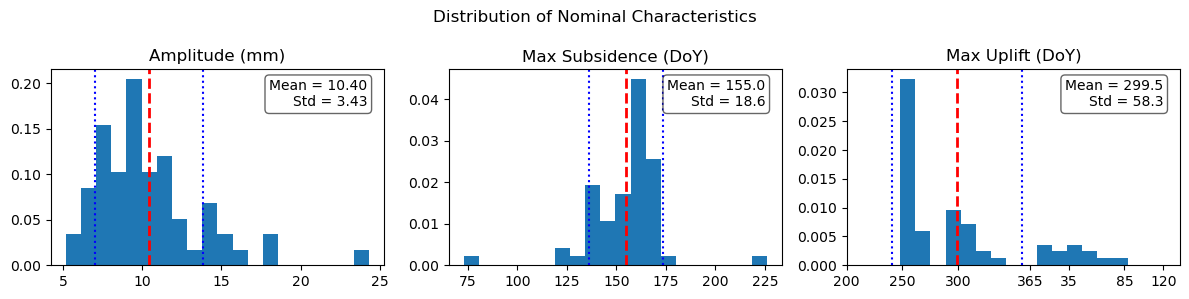

In [125]:
peak_doy_shifted = datavert['Peak_DoY'].copy()
peak_doy_shifted = peak_doy_shifted.apply(lambda x: x+365 if x < 165 else x)

fig, ax = plt.subplots(1,3, figsize=(12, 3)) ## Creates subplots

# ---- Amplitude ----
ax[0].hist(datavert['Amplitude'], bins=20, density=True)
ax[0].set_title('Amplitude (mm)')
mean_amp = datavert['Amplitude'].mean()
std_amp = datavert['Amplitude'].std()

# Lines
ax[0].axvline(mean_amp, color="red", linestyle="--", linewidth=2, label="Mean")
ax[0].axvline(mean_amp - std_amp, color="blue", linestyle=":", linewidth=1.5, label="±1 Std")
ax[0].axvline(mean_amp + std_amp, color="blue", linestyle=":", linewidth=1.5)

# Text
ax[0].text(0.95, 0.95, f"Mean = {mean_amp:.2f}\nStd = {std_amp:.2f}",
           transform=ax[0].transAxes, ha="right", va="top", fontsize=10,
           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.6))

# ---- Min_DoY ----
ax[1].hist(datavert['Min_DoY'], bins=20, density=True)
ax[1].set_title('Max Subsidence (DoY)')
mean_min = datavert['Min_DoY'].mean()
std_min = datavert['Min_DoY'].std()

ax[1].axvline(mean_min, color="red", linestyle="--", linewidth=2, label="Mean")
ax[1].axvline(mean_min - std_min, color="blue", linestyle=":", linewidth=1.5, label="±1 Std")
ax[1].axvline(mean_min + std_min, color="blue", linestyle=":", linewidth=1.5)

ax[1].text(0.95, 0.95, f"Mean = {mean_min:.1f}\nStd = {std_min:.1f}",
           transform=ax[1].transAxes, ha="right", va="top", fontsize=10,
           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.6))

# ---- Peak_DoY (shifted) ----
ax[2].hist(peak_doy_shifted, bins=15, density=True)
ax[2].set_title('Max Uplift (DoY)')
mean_peak = peak_doy_shifted.mean()
std_peak = peak_doy_shifted.std()

ax[2].axvline(mean_peak, color="red", linestyle="--", linewidth=2, label="Mean")
ax[2].axvline((mean_peak - std_peak),
              color="blue", linestyle=":", linewidth=1.5, label="±1 Std")
ax[2].axvline((mean_peak + std_peak) ,
              color="blue", linestyle=":", linewidth=1.5)

ax[2].text(0.95, 0.95, f"Mean = {mean_peak:.1f}\nStd = {std_peak:.1f}",
           transform=ax[2].transAxes, ha="right", va="top", fontsize=10,
           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.6))

# Axis wrapping for Peak_DoY
ax[2].set_xlim(200, 500)  
xticks = [200, 250, 300, 365, 400, 450, 485]
xtick_labels = [200, 250, 300, 365, 35, 85, 120] 
ax[2].set_xticks(xticks)
ax[2].set_xticklabels(xtick_labels)

plt.suptitle('Distribution of Nominal Characteristics')
plt.tight_layout()
plt.show()


### Outliers Removed
1. ILUL is the station that is the outlier for amplitude (but interesting enough it has a extremely small StDev and has 13.41 years of data!)
2. The outliers for subsidence are NNVN (smallest) (10.5 yrs of data) and THU1

In [111]:
datavertwooutliers = df_metricsavg[
    (df_metricsavg['disp'] == 'Vertical') & 
    (~df_metricsavg['station'].isin(['ILUL', 'THU1', 'NNVN']))
]

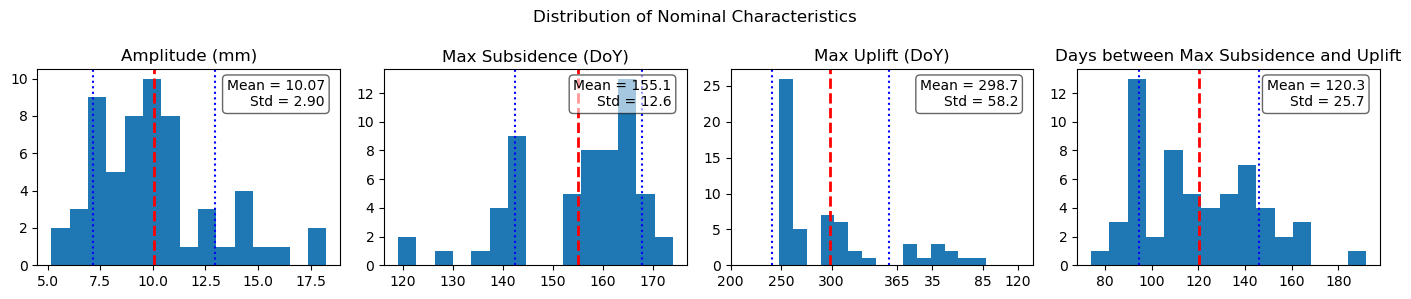

In [134]:
peak_doy_shifted = datavertwooutliers['Peak_DoY'].copy()
peak_doy_shifted = peak_doy_shifted.apply(lambda x: x+365 if x < 165 else x)

fig, ax = plt.subplots(1,4, figsize=(14, 3)) ## Creates subplots

# ---- Amplitude ----
ax[0].hist(datavertwooutliers['Amplitude'], bins=15,)
ax[0].set_title('Amplitude (mm)')
mean_amp = datavertwooutliers['Amplitude'].mean()
std_amp = datavertwooutliers['Amplitude'].std()

# Lines
ax[0].axvline(mean_amp, color="red", linestyle="--", linewidth=2, label="Mean")
ax[0].axvline(mean_amp - std_amp, color="blue", linestyle=":", linewidth=1.5, label="±1 Std")
ax[0].axvline(mean_amp + std_amp, color="blue", linestyle=":", linewidth=1.5)

# Text
ax[0].text(0.95, 0.95, f"Mean = {mean_amp:.2f}\nStd = {std_amp:.2f}",
           transform=ax[0].transAxes, ha="right", va="top", fontsize=10,
           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.6))

# ---- Min_DoY ----
ax[1].hist(datavertwooutliers['Min_DoY'], bins=15)
ax[1].set_title('Max Subsidence (DoY)')
mean_min = datavertwooutliers['Min_DoY'].mean()
std_min = datavertwooutliers['Min_DoY'].std()

ax[1].axvline(mean_min, color="red", linestyle="--", linewidth=2, label="Mean")
ax[1].axvline(mean_min - std_min, color="blue", linestyle=":", linewidth=1.5, label="±1 Std")
ax[1].axvline(mean_min + std_min, color="blue", linestyle=":", linewidth=1.5)

ax[1].text(0.95, 0.95, f"Mean = {mean_min:.1f}\nStd = {std_min:.1f}",
           transform=ax[1].transAxes, ha="right", va="top", fontsize=10,
           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.6))

# ---- Peak_DoY (shifted) ----
ax[2].hist(peak_doy_shifted, bins=15)
ax[2].set_title('Max Uplift (DoY)')
mean_peak = peak_doy_shifted.mean()
std_peak = peak_doy_shifted.std()

ax[2].axvline(mean_peak, color="red", linestyle="--", linewidth=2, label="Mean")
ax[2].axvline((mean_peak - std_peak),
              color="blue", linestyle=":", linewidth=1.5, label="±1 Std")
ax[2].axvline((mean_peak + std_peak),
              color="blue", linestyle=":", linewidth=1.5)

ax[2].text(0.95, 0.95, f"Mean = {mean_peak:.1f}\nStd = {std_peak:.1f}",
           transform=ax[2].transAxes, ha="right", va="top", fontsize=10,
           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.6))

# Axis wrapping for Peak_DoY
ax[2].set_xlim(200, 500)  
xticks = [200, 250, 300, 365, 400, 450, 485]
xtick_labels = [200, 250, 300, 365, 35, 85, 120] 
ax[2].set_xticks(xticks)
ax[2].set_xticklabels(xtick_labels)

# ---- Min_DoY ----
ax[3].hist(datavertwooutliers['Time_PeaktoMin'], bins=15)
ax[3].set_title('Days between Max Subsidence and Uplift')
mean_min = datavertwooutliers['Time_PeaktoMin'].mean()
std_min = datavertwooutliers['Time_PeaktoMin'].std()

ax[3].axvline(mean_min, color="red", linestyle="--", linewidth=2, label="Mean")
ax[3].axvline(mean_min - std_min, color="blue", linestyle=":", linewidth=1.5, label="±1 Std")
ax[3].axvline(mean_min + std_min, color="blue", linestyle=":", linewidth=1.5)

ax[3].text(0.95, 0.95, f"Mean = {mean_min:.1f}\nStd = {std_min:.1f}",
           transform=ax[3].transAxes, ha="right", va="top", fontsize=10,
           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.6))

plt.suptitle('Distribution of Nominal Characteristics')
plt.tight_layout()
plt.show()


Distribution (range, mean, guassian --> histogram)
new plot of dT
- How long does it take to uplift? Is there a correlation between this and amplitude? is this localized?

counts, bins = np.histogram(datavert['Max_DoY'], bins = 20)
plt.stairs(counts, bins)

## Histogram pt 2
plotting of all years of data instead of average

In [141]:
DispAll = ['Vertical']
recordsay = []

for station_name in stations_names_with_data:
    LTM = pd.read_csv(f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/{station_name}_Daily30RollingLTM.csv')

    smdt = StationMetaData.loc[StationMetaData['station'] == station_name]
    lon, lat = smdt.longitude, smdt.latitude

    for Disp in DispAll:
        raw_data = get_data(station_name)
        INTERP_LIMIT = 8  
        wdays = 30
        rd_data = InterpRA(raw_data, True, INTERP_LIMIT, wdays)

        max_ay, min_ay, amp_ay, dt_ay = [], [], [], []

        years = sorted(np.unique(rd_data.year))

        for year in years:
            data = rd_data[rd_data['year'] == year].copy()

            if data[Disp].count() < 350:
                continue
            data = data[Disp] - np.nanmean(data[Disp])

            recordsay.append({
                        "station": station_name,
                        "lon": lon,
                        "lat": lat,
                        "disp": Disp,
                        "year": year,
                        "Amplitude": np.max(data.values) - np.min(data.values),
                        "Peak_DoY": np.argmax(data.values),
                        "Min_DoY": np.argmin(data.values),
                        "Time_PeaktoMin": np.abs(np.argmax(data.values) - np.argmin(data.values) ),
                    })
            
df_metricsay = pd.DataFrame(recordsay)

In [142]:
df_metricsay

,station,lon,lat,disp,year,Amplitude,Peak_DoY,Min_DoY,Time_PeaktoMin
0,JWLF,"1 -45.119847 Name: longitude, dtype: float64","1 83.111656 Name: latitude, dtype: float64",Vertical,2009,11.058918,40,105,65
1,JWLF,"1 -45.119847 Name: longitude, dtype: float64","1 83.111656 Name: latitude, dtype: float64",Vertical,2010,10.613511,307,86,221
2,JWLF,"1 -45.119847 Name: longitude, dtype: float64","1 83.111656 Name: latitude, dtype: float64",Vertical,2011,15.332429,364,174,190
3,JWLF,"1 -45.119847 Name: longitude, dtype: float64","1 83.111656 Name: latitude, dtype: float64",Vertical,2015,10.132322,2,164,162
4,JWLF,"1 -45.119847 Name: longitude, dtype: float64","1 83.111656 Name: latitude, dtype: float64",Vertical,2016,13.566283,58,136,78
...,...,...,...,...,...,...,...,...,...
803,NRSK,"75 -17.725419 Name: longitude, dtype: float64","75 79.155031 Name: latitude, dtype: float64",Vertical,2020,13.014793,364,6,358
804,NRSK,"75 -17.725419 Name: longitude, dtype: float64","75 79.155031 Name: latitude, dtype: float64",Vertical,2021,13.057380,285,158,127
805,NRSK,"75 -17.725419 Name: longitude, dtype: float64","75 79.155031 Name: latitude, dtype: float64",Vertical,2022,16.704084,273,69,204
806,NRSK,"75 -17.725419 Name: longitude, dtype: float64","75 79.155031 Name: latitude, dtype: float64",Vertical,2023,10.491793,306,165,141


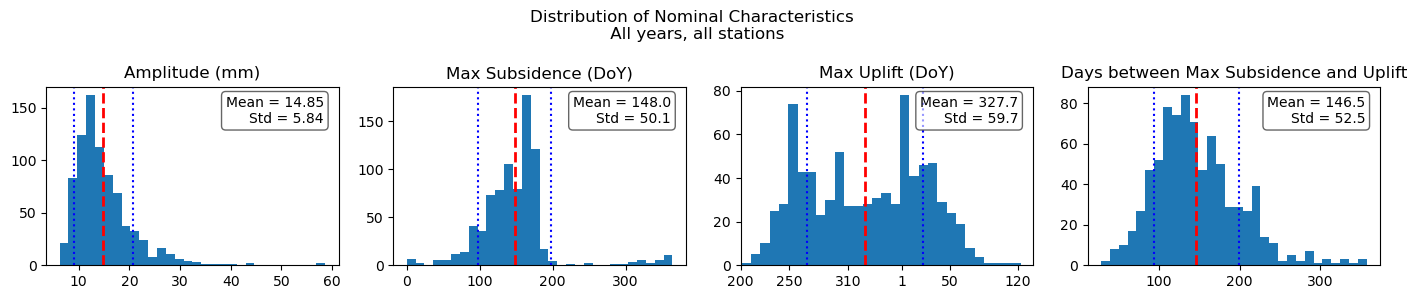

In [156]:
data = df_metricsay
bins = 30

peak_doy_shifted = data['Peak_DoY'].copy()
peak_doy_shifted = peak_doy_shifted.apply(lambda x: x+365 if x < 165 else x)

fig, ax = plt.subplots(1,4, figsize=(14, 3)) ## Creates subplots

# ---- Amplitude ----
ax[0].hist(data['Amplitude'], bins=bins,)
ax[0].set_title('Amplitude (mm)')
mean_amp = data['Amplitude'].mean()
std_amp = data['Amplitude'].std()

# Lines
ax[0].axvline(mean_amp, color="red", linestyle="--", linewidth=2, label="Mean")
ax[0].axvline(mean_amp - std_amp, color="blue", linestyle=":", linewidth=1.5, label="±1 Std")
ax[0].axvline(mean_amp + std_amp, color="blue", linestyle=":", linewidth=1.5)

# Text
ax[0].text(0.95, 0.95, f"Mean = {mean_amp:.2f}\nStd = {std_amp:.2f}",
           transform=ax[0].transAxes, ha="right", va="top", fontsize=10,
           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.6))

# ---- Min_DoY ----
ax[1].hist(data['Min_DoY'], bins=bins)
ax[1].set_title('Max Subsidence (DoY)')
mean_min = data['Min_DoY'].mean()
std_min = data['Min_DoY'].std()

ax[1].axvline(mean_min, color="red", linestyle="--", linewidth=2, label="Mean")
ax[1].axvline(mean_min - std_min, color="blue", linestyle=":", linewidth=1.5, label="±1 Std")
ax[1].axvline(mean_min + std_min, color="blue", linestyle=":", linewidth=1.5)

ax[1].text(0.95, 0.95, f"Mean = {mean_min:.1f}\nStd = {std_min:.1f}",
           transform=ax[1].transAxes, ha="right", va="top", fontsize=10,
           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.6))

# ---- Peak_DoY (shifted) ----
ax[2].hist(peak_doy_shifted, bins=bins)
ax[2].set_title('Max Uplift (DoY)')
mean_peak = peak_doy_shifted.mean()
std_peak = peak_doy_shifted.std()

ax[2].axvline(mean_peak, color="red", linestyle="--", linewidth=2, label="Mean")
ax[2].axvline((mean_peak - std_peak),
              color="blue", linestyle=":", linewidth=1.5, label="±1 Std")
ax[2].axvline((mean_peak + std_peak),
              color="blue", linestyle=":", linewidth=1.5)

ax[2].text(0.95, 0.95, f"Mean = {mean_peak:.1f}\nStd = {std_peak:.1f}",
           transform=ax[2].transAxes, ha="right", va="top", fontsize=10,
           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.6))

# Axis wrapping for Peak_DoY
ax[2].set_xlim(200, 500)  
xticks = [200, 250, 310, 366, 365+50, 485]
xtick_labels = [200, 250, 310 , 1, 50, 120] 
ax[2].set_xticks(xticks)
ax[2].set_xticklabels(xtick_labels)

# ---- Min_DoY ----
ax[3].hist(data['Time_PeaktoMin'], bins=bins)
ax[3].set_title('Days between Max Subsidence and Uplift')
mean_min = data['Time_PeaktoMin'].mean()
std_min = data['Time_PeaktoMin'].std()

ax[3].axvline(mean_min, color="red", linestyle="--", linewidth=2, label="Mean")
ax[3].axvline(mean_min - std_min, color="blue", linestyle=":", linewidth=1.5, label="±1 Std")
ax[3].axvline(mean_min + std_min, color="blue", linestyle=":", linewidth=1.5)

ax[3].text(0.95, 0.95, f"Mean = {mean_min:.1f}\nStd = {std_min:.1f}",
           transform=ax[3].transAxes, ha="right", va="top", fontsize=10,
           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.6))

plt.suptitle('Distribution of Nominal Characteristics \n All years, all stations')
plt.tight_layout()
plt.show()